# Sensor Analysis

[**`sensor-data.csv`**](sensor-data.csv)

Format 1677 columns:

* `timestamp` (1 column, float, seconds)
* `command` (1 column, string, execution description)
* `x`, `y`, `z` (position, 3 columns, float, meters, global coordinates)
* `alpha`, `beta`, `gamma` (orientation, 3 columns, float, radians, global coordinates)
* `sonar_1`-`sonar_16` (ultrasonic sensor readings, 16 columns, float, meters, robot coordinates)
* `laser_1_x`-`laser_551_z` (laser sensor readings, 1653 columns, float, meters, robot coordinates)
    - at most 551 readings of each x, y, z component (empty when no readings)


In [1]:
using DataFrames
using CSV
using Plots
using StatsPlots
using Images
pyplot()

Plots.PyPlotBackend()

In [2]:
@time sensor_data = CSV.read("sensor-data.csv");

 12.053879 seconds (15.60 M allocations: 760.346 MiB, 6.33% gc time)


In [3]:
first(sensor_data, 10)

,timestamp,command,x,y,z,alpha,beta
,Float64,String⍰,Float64,Float64,Float64,Float64,Float64
1,1.56997e9,missing,-2.025,-0.824999,0.138793,-0.0,0.0
2,1.56997e9,move 1.0 1.0,-1.93121,-0.825021,0.138671,-8.33892e-5,-0.00205561
3,1.56997e9,move 1.0 1.0,-1.85807,-0.825042,0.138686,-6.92512e-5,-0.0017769
4,1.56997e9,move 1.0 1.0,-1.80927,-0.82505,0.138698,-8.19824e-5,-0.00145289
5,1.56997e9,move 1.0 1.0,-1.73615,-0.825052,0.1387,-7.54623e-5,-0.00138658
6,1.56997e9,move 1.0 1.0,-1.68742,-0.825054,0.1387,-7.35961e-5,-0.00142729
7,1.56997e9,move 1.0 1.0,-1.61432,-0.825051,0.138696,-4.89615e-5,-0.00153992
8,1.56997e9,move 1.0 1.0,-1.56558,-0.825058,0.138697,-8.82266e-5,-0.00151759
9,1.56997e9,move 1.0 1.0,-1.49246,-0.82507,0.138697,-4.56239e-5,-0.00147799


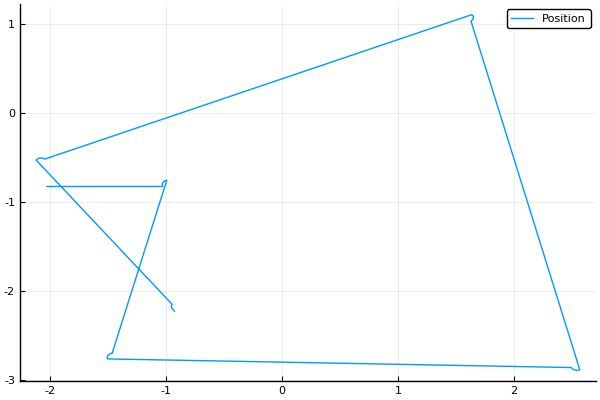

In [4]:
@df sensor_data plot(:x, :y, label="Position")

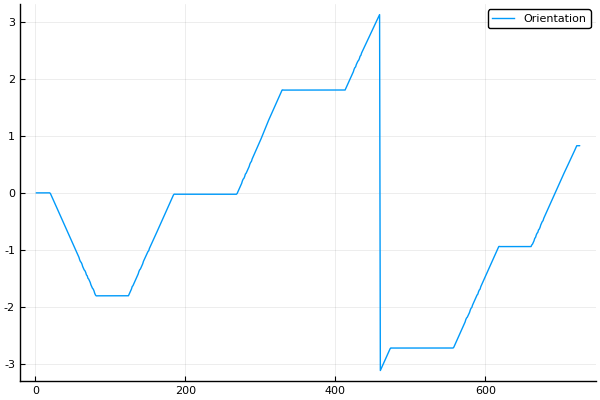

In [5]:
@df sensor_data plot(:gamma, label="Orientation")

## Transformation between Coordinates

Lecture 6 - Locomotion II [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2005%20-%20LocomotionII.pdf) ]

Given:

* $x$, $y$, $\theta$ - pose of the robot in Global Coordinates
* $x_{r}$, $y_{r}$ - position in Robot Coordinate.
* $x_{g}$, $y_{g}$ - position in Robot Coordinate.


**Robot Coordinates to Global Coordinates (World)**

$$
\begin{bmatrix}
x_{g} \\
y_{g} \\
1
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & x \\
0 & 1 & y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) &  \cos(\theta) & 0 \\
0            &  0            & 1
\end{bmatrix}
\begin{bmatrix}
x_{r} \\
y_{r} \\
1
\end{bmatrix} \\
$$

**Global Coordinates to Robot Coordinates**

$$
\begin{bmatrix}
x_{r} \\
y_{r} \\
1
\end{bmatrix}
=
\begin{bmatrix}
 \cos(\theta) & \sin(\theta) & 0 \\
-\sin(\theta) & \cos(\theta) & 0 \\
 0            & 0            & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & -x \\
0 & 1 & -y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{g} \\
y_{g} \\
1
\end{bmatrix} \\
$$


In [6]:
function T_r2g(x, y, θ)
    Ttrans = [1.0 0.0 x
              0.0 1.0 y
              0.0 0.0 1.0]
    Trot = [cos(θ) -sin(θ) 0.0
            sin(θ)  cos(θ) 0.0
            0.0     0.0    1.0]
    return Ttrans * Trot
end

function coords_global(x, y, θ, xr, yr)
    T = T_r2g(x, y, θ)
    R = [xr
         yr
         1]
    xg, yg, _ = T * R

    return xg, yg
end

xg, yg = coords_global(2.0, 3.0, 30π/180, 0.5, 1.0)

# G = (1.933, 4.116)
println("Robot (0.5, 1.0) -> Global (", round(xg, digits=3), ", ", round(yg, digits=3), ")")

Robot (0.5, 1.0) -> Global (1.933, 4.116)


In [7]:
function T_g2r(x, y, θ)
    Trot = [ cos(θ) sin(θ) 0.0
            -sin(θ) cos(θ) 0.0
             0.0    0.0    1.0]
    Ttrans = [1.0 0.0 -x
              0.0 1.0 -y
              0.0 0.0 1.0]
    return Trot * Ttrans
end

function coords_robot(x, y, θ, xg, yg)
    T = T_g2r(x, y, θ)
    G = [xg
         yg
         1]
    xr, yr, _ = T * G

    return xr, yr
end

xr, yr = coords_robot(4.0, 2.0, 30π/180, 3.0, 5.0)

# R = (0.634, 3.098)
println("Global (3.0, 5.0) -> Robot (", round(xr, digits=3), ", ", round(yr, digits=3), ")")

Global (3.0, 5.0) -> Robot (0.634, 3.098)


## Point Cloud - Laser Sensor

In [8]:
N = (ncol(sensor_data) - 24) ÷ 3

551

In [9]:
laser_cols = [Symbol(string("laser_", i, "_", d)) for d=["x", "y"], i=1:N]
laser_cols = reshape(laser_cols, length(laser_cols))

size(laser_cols)

(1102,)

In [10]:
laser_cols[1:10]

10-element Array{Symbol,1}:
 :laser_1_x
 :laser_1_y
 :laser_2_x
 :laser_2_y
 :laser_3_x
 :laser_3_y
 :laser_4_x
 :laser_4_y
 :laser_5_x
 :laser_5_y

In [11]:
X = Vector{Vector{Float64}}()
Y = Vector{Vector{Float64}}()

for r in eachrow(sensor_data)
    x, y, θ = r[[:x, :y, :gamma]]
    # Get laser readings (ignore missing data)
    laser_data = collect(skipmissing(r[laser_cols]))
    # Reshape 2xN (N = number of readings, dim=1 is x coord, dim=2 is y coord)
    laser_data = reshape(laser_data, 2, length(laser_data)÷2)
    # Add an extra dim with 1 required for coordinate tranformation R -> G
    d3 = ones(1, size(laser_data)[2])
    laser_data = vcat(laser_data, d3)
    # Tranform coordinates from R to G
    T = T_r2g(x, y, θ)
    laser_data = T * laser_data

    push!(X, laser_data[1, :])
    push!(Y, laser_data[2, :])    
end

X = vcat(X...)
Y = vcat(Y...)

println(size(X))
println(size(Y))

(400026,)
(400026,)


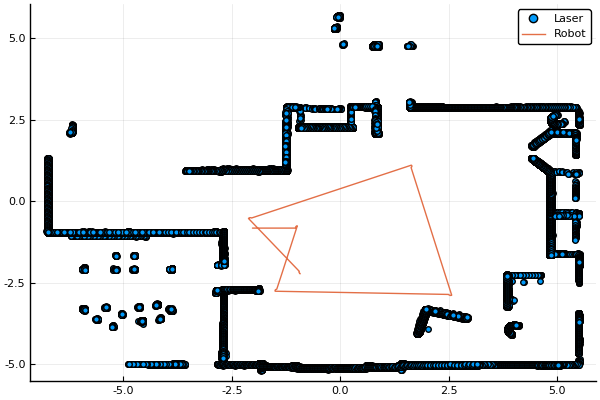

In [12]:
scatter(X, Y, label="Laser")
@df sensor_data plot!(:x, :y, label="Robot")

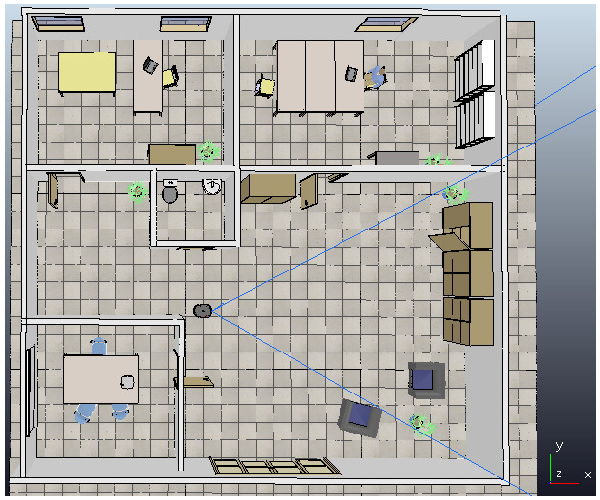

In [13]:
scene_img = load("scene.jpg")

plot(scene_img, size=(600, 500),
    ticks=nothing, border=:none)